<a href="https://colab.research.google.com/github/ab-sa/Statistical-Machine-Learning-2/blob/main/Lecture7_LDA_QDA_NB_KDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
Credit = pd.read_csv('Credit.csv')
Credit['Balance_multi'] = pd.cut(Credit.Balance, bins=[-1,300,700,2000],labels=['0','1','2'])
Credit = Credit.drop(['ID', 'Balance', 'Limit', 'Rating'], axis=1)
print('Dimension of the data: ' + str(Credit.shape))
Credit.head()

Dimension of the data: (400, 9)


,Income,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance_multi
0,14.891,2,34,11,Male,No,Yes,Caucasian,1
1,106.025,3,82,15,Female,Yes,Yes,Asian,2
2,104.593,4,71,11,Male,No,No,Asian,1
3,148.924,3,36,11,Female,No,No,Asian,2
4,55.882,2,68,16,Male,No,Yes,Caucasian,1


**Linear Discriminant Analysis (LDA)**: Fit an LDA with Balance_bin as response:

In [ ]:
# data: dropping the credit-card related features (Limit & Rating) to make the classification problem more challenging
X = pd.get_dummies(Credit.drop(['Balance_multi'], axis=1))
y = Credit['Balance_multi']
# CV
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define model
LDA_mod = LinearDiscriminantAnalysis()
# evaluate model
LDA_scores = cross_val_score(LDA_mod, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy for LDA: %.3f (%.3f)' % (np.mean(LDA_scores), np.std(LDA_scores)))

Mean Accuracy for LDA: 0.505 (0.084)


Visualizing of pairwise DLs

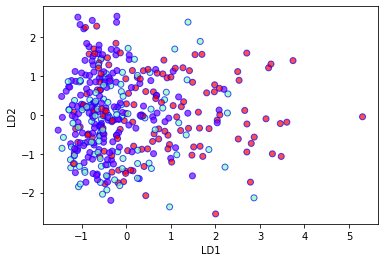

In [ ]:
X_lda = LDA_mod.fit_transform(X, y)
plt.xlabel('LD1')
plt.ylabel('LD2')
le = LabelEncoder()
y_lab = le.fit_transform(Credit['Balance_multi'])
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_lab,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b')

**Quadratic Discriminant Analysis (QDA)**: Fit an QDA with Balance_bin as response:

In [ ]:
# define model
QDA_mod = QuadraticDiscriminantAnalysis()
# evaluate model
QDA_scores = cross_val_score(QDA_mod, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy for QDA: %.3f (%.3f)' % (np.mean(QDA_scores), np.std(QDA_scores)))

Mean Accuracy for QDA: 0.374 (0.071)


**Gaussian Naive Bayes (G-NB)**

Visializing density of different features:

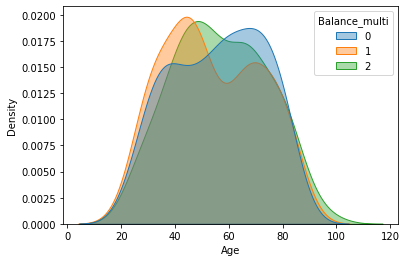

In [ ]:
sns.kdeplot(data=Credit, x="Age", hue="Balance_multi", fill=True, common_norm=False, alpha=0.4)
plt.show()

G-NB fit on Balance_bin with the original features (no PCA):

In [ ]:
# define model
NB_mod = GaussianNB()
# evaluate model
NB_scores = cross_val_score(NB_mod, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy for G-NB: %.3f (%.3f)' % (np.mean(NB_scores), np.std(NB_scores)))

Mean Accuracy for G-NB: 0.494 (0.071)


G-NB fit on Balance_bin with PCs:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# PCA
std_scale = StandardScaler().fit(x_train)
X_train_std = std_scale.transform(x_train)
X_test_std = std_scale.transform(x_test)

pca = PCA()
PCs_train = pd.DataFrame(pca.fit_transform(X_train_std))
PCs_test = pd.DataFrame(pca.transform(X_test_std))

# define model
NB_pc_mod = GaussianNB().fit(PCs_train, y_train)
NB_pc_pred = NB_pc_mod.predict(PCs_test)

# summarize result
print(accuracy_score(y_test, NB_pc_pred))
print(confusion_matrix(y_test, NB_pc_pred, normalize='true'))

0.5625
[[0.82758621 0.13793103 0.03448276]
 [0.69565217 0.17391304 0.13043478]
 [0.32142857 0.07142857 0.60714286]]


**Kernel density estimation naive Bayes (KDE-NB)**

KDE-NB fit on Balance_bin with the original features (no PCA):

In [ ]:
class KDE_NB(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

#class KDE_NB(BaseEstimator, ClassifierMixin):
#    """Bayesian generative classification based on KDE
#    
#    Parameters
#    ----------
#    bandwidth : float
#        the kernel bandwidth within each class
#    kernel : str
#        the kernel name, passed to KernelDensity
#    """

def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel

def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self

def predict_proba(self, X):
        logprobs = np.vstack([model.score_samples(X)
                              for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)

def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]


In [ ]:
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDE_NB(), {'bandwidth': bandwidths})
grid.fit(X, y)

print(grid.best_params_)
print('accuracy =', grid.best_score_)
#scores = [val.mean_validation_score for val in grid.grid_scores_]

{'bandwidth': 17.886495290574352}
accuracy = 0.5049999999999999
